In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import skew, skewtest
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

In [25]:
df = pd.read_csv('input/train_custom.csv', index_col=0)
test = pd.read_csv('input/test_custom.csv',index_col=0)

# Missing

In [26]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Total'] > 0]

,Total,Percent
PoolQC,1451,0.995882
MiscFeature,1403,0.962938
Alley,1366,0.937543
Fence,1176,0.807138
FireplaceQu,689,0.472889
LotFrontage,259,0.177763
GarageType,81,0.055594
GarageFinish,81,0.055594
GarageQual,81,0.055594
GarageCond,81,0.055594


In [27]:
# Processing all features
joined_df = pd.concat([df,test])

In [28]:
# Impute Lot Frontage using the naighbourhood median
lot_frontage_by_neighborhood = joined_df["LotFrontage"].groupby(df["Neighborhood"])

for key, group in lot_frontage_by_neighborhood:
    idx = (joined_df["Neighborhood"] == key) & (joined_df["LotFrontage"].isnull())
    joined_df.loc[idx, "LotFrontage"] = group.median()  

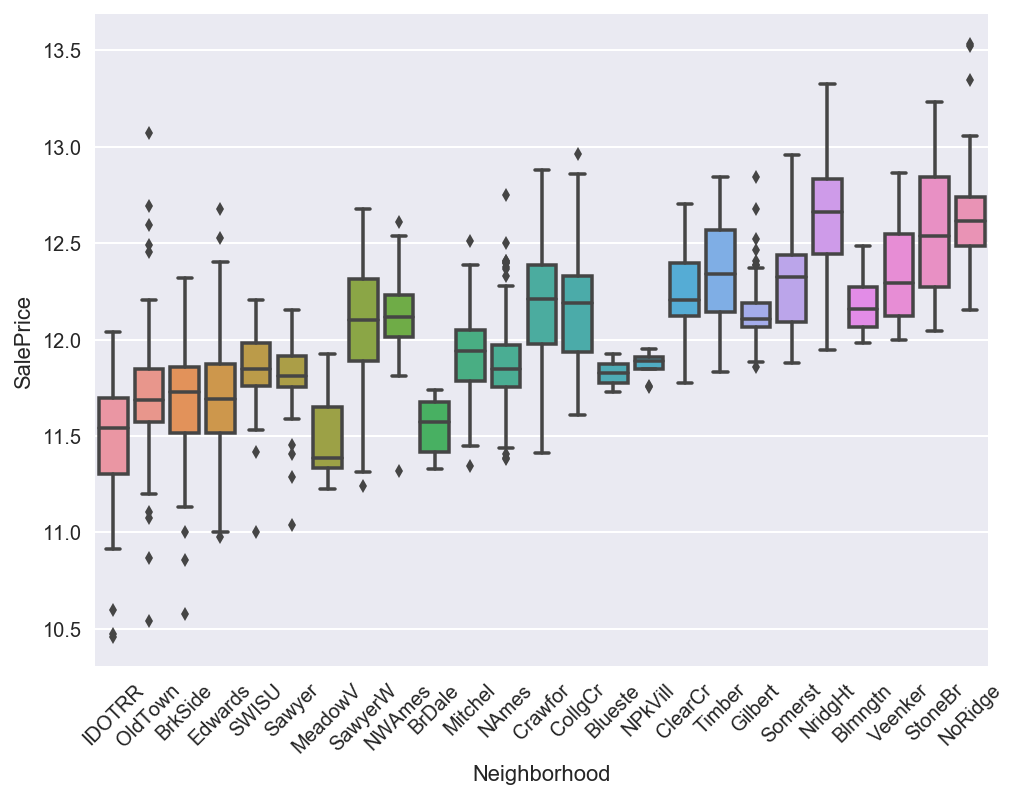

In [29]:
# Clustering the neighbourhoods
interesting_attributes = ['Neighborhood','SalePrice']
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=interesting_attributes[0], y="SalePrice", data=df[interesting_attributes].sort_values(by='SalePrice'))
plt.xticks(rotation=45)

joined_df.loc[joined_df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
joined_df.loc[joined_df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
joined_df.loc[joined_df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
joined_df.loc[joined_df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
joined_df.loc[joined_df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
joined_df["Neighborhood_Good"].fillna(0, inplace=True)

In [30]:
# Central Air as binary feature
joined_df['CentralAir'] = joined_df['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0) 

# Has been remodeled?
joined_df["Remodeled"] = (joined_df["YearRemodAdd"] != joined_df["YearBuilt"]) * 1

#Has been remodeled recently
joined_df["RecentRemodel"] = (joined_df["YearRemodAdd"] == joined_df["YrSold"]) * 1

# Single owner?
joined_df["SingleOwner"] = (joined_df["YearBuilt"] == joined_df["YrSold"]) * 1

In [31]:
joined_df["Has2ndFloor"] = (joined_df["2ndFlrSF"] == 0) * 1
joined_df["HasMasVnr"] = (joined_df["MasVnrArea"] == 0) * 1
joined_df["HasWoodDeck"] = (joined_df["WoodDeckSF"] == 0) * 1
joined_df["HasOpenPorch"] = (joined_df["OpenPorchSF"] == 0) * 1
joined_df["HasEnclosedPorch"] = (joined_df["EnclosedPorch"] == 0) * 1
joined_df["Has3SsnPorch"] = (joined_df["3SsnPorch"] == 0) * 1
joined_df["HasScreenPorch"] = (joined_df["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
joined_df["HighSeason"] = joined_df["MoSold"].replace( 
    {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

joined_df["NewerDwelling"] = joined_df["MSSubClass"].replace(
    {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
     90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   


joined_df["SaleCondition_PriceDown"] = joined_df.SaleCondition.replace(
    {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
joined_df["BoughtOffPlan"] = joined_df.SaleCondition.replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

joined_df["BadHeating"] = joined_df.HeatingQC.replace(
    {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
joined_df["TotalArea"] = joined_df[area_cols].sum(axis=1)

joined_df["Age"] = 2010 - joined_df["YearBuilt"]
joined_df["TimeSinceSold"] = 2010 - joined_df["YrSold"]

joined_df["SeasonSold"] = joined_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                              6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)

joined_df["YearsSinceRemodel"] = joined_df["YrSold"] - joined_df["YearRemodAdd"]

# Simplifications of existing features into bad/average/good.
joined_df["SimplOverallQual"] = joined_df.OverallQual.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
joined_df["SimplOverallCond"] = joined_df.OverallCond.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
joined_df["SimplPoolQC"] = joined_df.PoolQC.replace(
    {1 : 1, 2 : 1, 3 : 2, 4 : 2})
joined_df["SimplGarageCond"] = joined_df.GarageCond.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplGarageQual"] = joined_df.GarageQual.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplFireplaceQu"] = joined_df.FireplaceQu.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplFireplaceQu"] = joined_df.FireplaceQu.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplFunctional"] = joined_df.Functional.replace(
    {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
joined_df["SimplKitchenQual"] = joined_df.KitchenQual.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplHeatingQC"] = joined_df.HeatingQC.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplBsmtFinType1"] = joined_df.BsmtFinType1.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
joined_df["SimplBsmtFinType2"] = joined_df.BsmtFinType2.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
joined_df["SimplBsmtCond"] = joined_df.BsmtCond.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplBsmtQual"] = joined_df.BsmtQual.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplExterCond"] = joined_df.ExterCond.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
joined_df["SimplExterQual"] = joined_df.ExterQual.replace(
    {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

In [32]:
joined_df["MasVnrArea"].fillna(0, inplace=True)
joined_df["BsmtFinSF1"].fillna(0, inplace=True)
joined_df["BsmtFinSF2"].fillna(0, inplace=True)
joined_df["BsmtUnfSF"].fillna(0, inplace=True)
joined_df["TotalBsmtSF"].fillna(0, inplace=True)
joined_df["GarageArea"].fillna(0, inplace=True)
joined_df["BsmtFullBath"].fillna(0, inplace=True)
joined_df["BsmtHalfBath"].fillna(0, inplace=True)
joined_df["GarageCars"].fillna(0, inplace=True)

# Quality measurements are stored as text but we can convert them to 
# numbers where a higher number means higher quality.

qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
joined_df["ExterQual"] = joined_df["ExterQual"].map(qual_dict).astype(int)
joined_df["ExterCond"] = joined_df["ExterCond"].map(qual_dict).astype(int)
joined_df["BsmtQual"] = joined_df["BsmtQual"].map(qual_dict).astype(int)
joined_df["BsmtCond"] = joined_df["BsmtCond"].map(qual_dict).astype(int)
joined_df["HeatingQC"] = joined_df["HeatingQC"].map(qual_dict).astype(int)
joined_df["KitchenQual"] = joined_df["KitchenQual"].map(qual_dict).astype(int)
joined_df["FireplaceQu"] = joined_df["FireplaceQu"].map(qual_dict).astype(int)
joined_df["GarageQual"] = joined_df["GarageQual"].map(qual_dict).astype(int)
joined_df["GarageCond"] = joined_df["GarageCond"].map(qual_dict).astype(int)

joined_df["BsmtExposure"] = joined_df["BsmtExposure"].map(
    {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
joined_df["BsmtFinType1"] = joined_df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
joined_df["BsmtFinType2"] = joined_df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

joined_df["Functional"] = joined_df["Functional"].map(
    {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
     "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

joined_df["GarageFinish"] = joined_df["GarageFinish"].map(
    {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

joined_df["Fence"] = joined_df["Fence"].map(
    {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

joined_df["GarageYrBlt"].fillna(0.0, inplace=True)
joined_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)
joined_df["PoolQC"].fillna(0, inplace=True)
joined_df["SimplPoolQC"].fillna(0, inplace=True)
joined_df["PoolArea"].fillna(0, inplace=True)

joined_df["SimplFireplaceQu"].fillna(0, inplace=True)
joined_df["SimplGarageCond"].fillna(0, inplace=True)
joined_df["SimplGarageCond"].fillna(0, inplace=True)


joined_df["HasShed"] = (joined_df["MiscFeature"] == "Shed") * 1.  
joined_df.drop('MiscFeature',1, inplace=1)

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
joined_df["IsRegularLotShape"] = (joined_df["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
joined_df["IsLandLevel"] = (joined_df["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
joined_df["IsLandSlopeGentle"] = (joined_df["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
joined_df["IsElectricalSBrkr"] = (joined_df["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
joined_df["IsGarageDetached"] = (joined_df["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
joined_df["IsPavedDrive"] = (joined_df["PavedDrive"] == "Y") * 1

In [33]:
for c in ['SimplFireplaceQu', 'SimplGarageCond',
       'SimplGarageQual',  'SimplBsmtCond', 'SimplBsmtQual',
       'SimplBsmtFinType2', 'SimplBsmtFinType1']:
    joined_df[c].fillna(0, inplace=True)

In [34]:
joined_df.drop('GarageType',1,inplace=True)
joined_df.drop('Alley',1,inplace=True)

In [35]:
joined_df['HasBsmt'] = (joined_df['TotalBsmtSF']>0) * 1
joined_df['1stFlr_2ndFlr_Sf'] = joined_df['1stFlrSF'] + joined_df['2ndFlrSF']

In [36]:
total = joined_df.isnull().sum().sort_values(ascending=False)
percent = (joined_df.isnull().sum()/joined_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Total'] > 0]

,Total,Percent
SalePrice,1459,0.500343
MasVnrType,24,0.008230
MSZoning,4,0.001372
SimplFunctional,2,0.000686
Utilities,2,0.000686
SimplKitchenQual,1,0.000343
Exterior1st,1,0.000343
Exterior2nd,1,0.000343
SaleType,1,0.000343


In [37]:
for m in missing_data[missing_data['Total'] > 0].index:
    if m == 'SalePrice': # We need this
        continue
    if joined_df[m].dtype == 'object': # Categorical -> Use most frequent category
        v = joined_df[m].value_counts().keys()[0]
    else: # Numerical -> Use mean
        v = joined_df[m].mean()
    joined_df.loc[joined_df[m].isnull().index,m] = v

## Normalization... again

In [38]:
numeric_features = joined_df.dtypes[joined_df.dtypes != "object"].index

In [39]:
skewed = joined_df[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

In [40]:
joined_df[skewed] = np.log1p(joined_df[skewed])

## Encoding

In [42]:
joined_df.sample()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Neighborhood_Good,Remodeled,RecentRemodel,SingleOwner,Has2ndFloor,HasMasVnr,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,HighSeason,NewerDwelling,SaleCondition_PriceDown,BoughtOffPlan,BadHeating,TotalArea,Age,TimeSinceSold,SeasonSold,YearsSinceRemodel,SimplOverallQual,SimplOverallCond,SimplPoolQC,SimplGarageCond,SimplGarageQual,SimplFireplaceQu,SimplFunctional,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,HasShed,IsRegularLotShape,IsLandLevel,IsLandSlopeGentle,IsElectricalSBrkr,IsGarageDetached,IsPavedDrive,HasBsmt,1stFlr_2ndFlr_Sf
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
260,6.783325,0.0,0.0,2,1Fam,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,1,Norm,Norm,FuseA,0.0,1.386294,1.386294,VinylSd,VinylSd,0.0,0,0,PConc,1,8,308.0,1.0,3,1,3,1956.0,6.783325,0,GasA,4,1Story,0.693147,3,Lvl,Gtl,9.449593,Inside,4.26268,Reg,0.0,3.044522,RL,0.0,None,0.0,12,OldTown,3.828641,5,5,Y,0.0,0.0,CompShg,Gable,Normal,11.482477,WD,0.0,Pave,4,0.0,AllPub,0.0,1956,1956,2008,0.0,0,0.0,0.0,1,1,1,0,1,1,1,0,1,0.0,0.0,0.0,9.608445,54,2,0,52,2,1.098612,0,TA,TA,0,Typ,TA,Gd,0,0,0,0,TA,TA,0.0,1,1,1,0,0.693147,1,0,6.783325


In [43]:
categorial_features = joined_df.select_dtypes(include=[object]).columns.values 
joined_df = pd.get_dummies(data=joined_df, columns=categorial_features)

## Scaling

In [44]:
# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler

numeric_features = list(set(numeric_features) - set(['SalePrice']))
scaler = StandardScaler()
scaler.fit(joined_df[numeric_features])

scaled = scaler.transform(joined_df[numeric_features])
for i, col in enumerate(numeric_features):
    joined_df[col] = scaled[:, i]

## Split

In [45]:
df = joined_df[joined_df.SalePrice.notnull()].copy()
test = joined_df[joined_df.SalePrice.isnull()].copy()
test.drop('SalePrice',1,inplace=True)

## Save

In [46]:
df.to_csv('input/train_custom_2.csv')
test.to_csv('input/test_custom_2.csv')